<a href="https://colab.research.google.com/github/MUMADE-TADM/s1_python-manunu93/blob/main/3_Copia_de_TADM2022_S04_Razonamiento_Aproximado_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

Apuntes:

Una técnica en caso de incertidumbre para clasificar varibles es el razonamiento aproximado, es una forma de asignar valores por grados, de esta forma una variable puede no necesariamente es A o B, puede ser x parte de A y x parte de B, con esto se puede aproximar. Para hacerlo de manera más precisa hay que utilizar estimadores robustos para que los resultados devueltos sean confiables, además los métodos robustos minimizan el ruido -> un estimador robusto es NaiveBayes

Para realizar un modelo predictivo es necesario tener un conjunto de train y de test para hacer probarlo, el conjunto de train será para entrenar el modelo y el conjunto de test para evaluarlo.

## Carga de Datos

In [ ]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 259MB/s]


1. Cargamos la extensión sql

In [ ]:
%load_ext sql

2. Nos conectamos con la base de datos

In [ ]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado?

In [ ]:
%%sql

SELECT status, count(*) as total
FROM  loan
GROUP BY status
ORDER BY total DESC



 * sqlite:///data_berka.db
Done.


status,total
C,403
A,203
D,45
B,31


Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0. 

Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

- CASE: ES CUANDO ; WHEN ES: ; THEN: AHORA

- SUBSTR ES PARA OBTENER LOS CARACTERES
- Y EL COMANDO ES PARA VOLCAR EN PYTHON ESA VARIABLE

- DONDE PROCEDE LAS TALBAS, INDICAS CON EL INNER JOIN Y LA RELACIÓN CON EL ON 

Para la variable train, con estos datos validaremos el modelo

In [ ]:
# el case sirve para actualizar el valor de las celdas de la columna
# si en la misma línea de %%sql [nombre del objeto] <<  y el select añade esa tabla a un objeto que luego por medio de pandas puedes guardarlo y trabajarlo en lenguaje python

%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13, 
  CASE status WHEN 'A' THEN 1 
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


3. Obtenemos el DataFrame

In [ ]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [ ]:
df_train.shape

(234, 7)

Para la parte de **test**, s va extraer la base de datos son los prestamos que están en ejecución (status in ("C", "D"). con los mismos campos de la consulta anterior

In [ ]:


%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


In [ ]:
df_test = loans_test.DataFrame()
df_test.head()


,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


Ejercicio: Añadir la edad del cliente propietario de la cuenta del prestamo.


In [ ]:
%%sql 
select substr(lo.date,0,3) concession_loan, amount, duration, payments, A11, A13, 99-substr(cl.birth_number,0,3) year ,lo.date,
CASE status WHEN 'A' THEN 1 --el case es una condición mas del select, sustityo los valores indicados
            WHEN 'B' THEN 0
END label
from LOAN lo, ACCOUNT ac, DISTRICT dist, CLIENT cl, DISPOSITION disp
where lo.account_id = ac.account_id
and ac.account_id = disp.account_id
and disp.client_id = cl.client_id
and cl.district_id = dist.a1
and lo.status in ("A", "B")
limit 10

 * sqlite:///data_berka.db
Done.


concession_loan,amount,duration,payments,A11,A13,year,date,label
94,80952,24,3373,12541,0.43,54,940105,1
94,80952,24,3373,12541,0.43,59,940105,1
96,30276,12,2523,9104,2.07,60,960429,0
97,30276,12,2523,9893,4.72,37,971208,1
96,165960,24,6915,8427,1.54,55,960502,1
97,102876,12,8573,10673,5.44,57,970810,1
97,102876,12,8573,10673,5.44,63,970810,1
96,88440,12,7370,9317,7.07,54,961106,1
96,88440,12,7370,9317,7.07,61,961106,1
94,104808,12,8734,8512,4.12,60,940531,1


Ejercicio: añadir la edad del cliente propietario de la cuenta del prestamo y algún campo de datos demográficos

In [ ]:
%%sql 
select substr(lo.date,0,3) concession_loan, amount, duration, payments, A11, A13, 99-substr(cl.birth_number,0,3) year ,lo.date, A16 criminalidad_16,
CASE status WHEN 'A' THEN 1 --el case es una condición mas del select, sustityo los valores indicados
            WHEN 'B' THEN 0
END label
from LOAN lo, ACCOUNT ac, DISTRICT dist, CLIENT cl, DISPOSITION disp
where lo.account_id = ac.account_id
and ac.account_id = disp.account_id
and disp.client_id = cl.client_id
and cl.district_id = dist.a1
and lo.status in ("A", "B")
limit 10

 * sqlite:///data_berka.db
Done.


concession_loan,amount,duration,payments,A11,A13,year,date,criminalidad_16,label
94,80952,24,3373,12541,0.43,54,940105,99107,1
94,80952,24,3373,12541,0.43,59,940105,99107,1
96,30276,12,2523,9104,2.07,60,960429,2354,0
97,30276,12,2523,9893,4.72,37,971208,5887,1
96,165960,24,6915,8427,1.54,55,960502,1913,1
97,102876,12,8573,10673,5.44,57,970810,18347,1
97,102876,12,8573,10673,5.44,63,970810,18347,1
96,88440,12,7370,9317,7.07,54,961106,6872,1
96,88440,12,7370,9317,7.07,61,961106,6872,1
94,104808,12,8734,8512,4.12,60,940531,2103,1


4. División de los datos en entrenamiento y test

`features`: es una variable de tipo lista que me almacena los nombres de las características que sirven como entrada

In [ ]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

- train (creación del modelo): datos de préstamos ya finalizados.
- Test (evaluación del modelo): datos de prestamos en ejecución

In [ ]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]


5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


Toda transformación de los datos debe ser con el conjunto de train ya que suponemos que los datos de test no sabemos, y luego se aplican las transformaciónes a train y test.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train

array([[-1.57281810e+00, -2.43174486e-02, -9.02269372e-01,
         1.62615210e+00, -1.48692036e-03,  6.65458047e-02],
       [-1.57281810e+00,  9.43740376e-01,  1.12783671e+00,
         8.80192763e-02, -9.12959978e-01, -5.34747122e-01],
       [-1.57281810e+00,  4.02683389e-01,  3.15794280e+00,
        -1.03176658e+00, -8.98017797e-01, -2.78313374e-01],
       ...,
       [ 1.59993565e+00, -7.28860482e-01, -9.02269372e-01,
        -2.69665131e-01, -5.92770380e-01,  9.46378837e-01],
       [ 1.59993565e+00, -7.69606749e-01, -9.02269372e-01,
        -3.79307085e-01,  3.73490677e-01,  1.87042459e+00],
       [ 1.59993565e+00, -2.54934640e-01, -9.02269372e-01,
         1.00559661e+00, -7.50019049e-01, -1.14726328e-01]])

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

- gaussian: para variables continuas
- multi: son para variables de conteo
- bernoulli: cuando las variables binarias
- compl: sirve para dataset no balanceado 

se pueden pasar los datos de un grupo a otro discretizando

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))


Número de préstamos clasificados erroneamente 448 de un total de  123


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

Classification_report esta para todas las api. Sirve para comprabar la valided

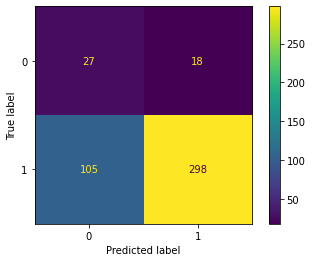

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

es una matriz de verdadero y label, esta matriz sirve para validar el modelo, Hay que tener encuenta el problema ya que el coste de un falso positivo o un falso negativo puede ser costoso.

**Ejercicios**

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).

Otras transformaciones: [Discretización](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization) y utilización de otros clasificadores NB

In [ ]:


%%sql 
select substr(lo.date,0,3) concession_loan, amount, duration, payments, A11, A13, 99-substr(cl.birth_number,0,3) year ,lo.date, a16 criminalidad,
CASE status WHEN 'A' THEN 1 --el case es una condición mas del select, sustityo los valores indicados
              WHEN 'B' THEN 0
END label
from LOAN lo, ACCOUNT ac, DISTRICT dist, CLIENT cl, DISPOSITION disp
where lo.account_id = ac.account_id
and ac.account_id = disp.account_id
and disp.client_id = cl.client_id
and cl.district_id = dist.a1
and lo.status in ("A", "B")
limit 10

 * sqlite:///data_berka.db
Done.


concession_loan,amount,duration,payments,A11,A13,year,date,criminalidad,label
94,80952,24,3373,12541,0.43,54,940105,99107,1
94,80952,24,3373,12541,0.43,59,940105,99107,1
96,30276,12,2523,9104,2.07,60,960429,2354,0
97,30276,12,2523,9893,4.72,37,971208,5887,1
96,165960,24,6915,8427,1.54,55,960502,1913,1
97,102876,12,8573,10673,5.44,57,970810,18347,1
97,102876,12,8573,10673,5.44,63,970810,18347,1
96,88440,12,7370,9317,7.07,54,961106,6872,1
96,88440,12,7370,9317,7.07,61,961106,6872,1
94,104808,12,8734,8512,4.12,60,940531,2103,1


In [ ]:
%%sql loans_train_2 << select substr(lo.date,0,3) concession_loan, amount, duration, payments, A11, A13, 99-substr(cl.birth_number,0,3) year ,lo.date, a16 criminalidad,
  CASE status WHEN 'A' THEN 1 
              WHEN 'B' THEN 0
  END label

  FROM LOAN lo inner join ACCOUNT ac on lo.account_id = ac.account_id
             inner join DISPOSITION disp on ac.account_id = disp.account_id
             inner join CLIENT cl on disp.client_id = cl.client_id
             inner join DISTRICT dist on cl.district_id = dist.a1
  Where lo.status in ("A", "B")


 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train_2


In [ ]:
df_train_2 = loans_train_2.DataFrame()
df_train_2.head()


,concession_loan,amount,duration,payments,A11,A13,year,date,criminalidad,label
0,94,80952,24,3373,12541,0.43,54,940105,99107,1
1,94,80952,24,3373,12541,0.43,59,940105,99107,1
2,96,30276,12,2523,9104,2.07,60,960429,2354,0
3,97,30276,12,2523,9893,4.72,37,971208,5887,1
4,96,165960,24,6915,8427,1.54,55,960502,1913,1


In [ ]:
df_train_2.shape

(289, 10)

In [ ]:
%%sql loans_test_2 << select substr(lo.date,0,3) concession_loan, amount, duration, payments, A11, A13, 99-substr(cl.birth_number,0,3) year ,lo.date, a16 criminalidad,
  CASE status WHEN 'C' THEN 1 
              WHEN 'D' THEN 0
  END label

  FROM LOAN lo inner join ACCOUNT ac on lo.account_id = ac.account_id
             inner join DISPOSITION disp on ac.account_id = disp.account_id
             inner join CLIENT cl on disp.client_id = cl.client_id
             inner join DISTRICT dist on cl.district_id = dist.a1
  Where lo.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test_2


In [ ]:
df_test_2 = loans_test_2.DataFrame()
df_test_2.head()

,concession_loan,amount,duration,payments,A11,A13,year,date,criminalidad,label
0,98,318480,60,5308,8547,3.64,47,981014,1542,0
1,98,110736,48,2307,8402,3.98,59,980419,1099,1
2,97,265320,36,7370,8254,3.76,32,971206,2325,0
3,98,352704,48,7348,9104,2.07,49,981205,2354,1
4,97,162576,36,4516,9198,4.28,46,970908,6132,1


In [ ]:
df_test_2.shape

(538, 10)

División de los datos de entrenamiento

In [ ]:
features = ["concession_loan", "amount", "duration", "A11", "A13", "year", "date", "criminalidad"]

In [ ]:
X_train_2 = df_train_2[features]
y_train_2 = df_train_2["label"]

X_test_2 = df_test_2[features]
y_test_2 = df_test_2["label"]

In [ ]:

scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train_2) 
# transformación
X_train_2 = scaler.transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [ ]:

gnb = GaussianNB()
clf = gnb.fit(X_train_2, y_train_2)
y_pred = clf.predict(X_test_2)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test_2.shape[0], (y_test_2 != y_pred).sum()))


Número de préstamos clasificados erroneamente 538 de un total de  149


In [ ]:

print(classification_report(y_test_2, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.16      0.53      0.24        45
           1       0.95      0.74      0.83       493

    accuracy                           0.72       538
   macro avg       0.55      0.64      0.54       538
weighted avg       0.88      0.72      0.78       538



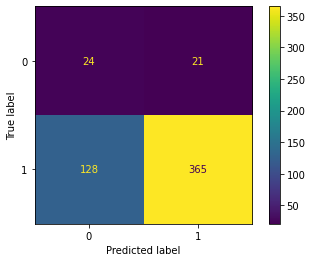

In [ ]:
cm = confusion_matrix(y_test_2, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

La diferencia entre NaiveBayes y realizar un razonamiento aproximado asignado las poderaciones de forma natural es los algoritmos de ML que estan detras de NaiveBayes que hacen que sea un modelo más robusto y mas confiable los resultados devueltos